In [1]:
import importlib
import pydicom as dicom

import data
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import cv2
import pickle
import models
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/amolmenon/Documents/Spring 2023/CMSC472/cmsc472_medicaldiagnosis/models.py'>

In [2]:
all_data = data.load_datasets()

train_set = all_data['combined']['train']
val_set = all_data['combined']['val']

In [3]:
batch_size = 32
learning_rate = 0.0001
epochs = 500

In [4]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [5]:
class MultiClassNet(nn.Module):

    def __init__(self, num_classes):
        super(MultiClassNet, self).__init__()
        self.procedure = nn.Sequential(
            nn.Linear(256 * 256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 256 * 256)
        return self.procedure(x)

In [6]:
num_classes = len(all_data.keys()) - 1
model = MultiClassNet(num_classes)
optim = torch.optim.SGD(model.parameters(), lr = learning_rate) 
loss_function = nn.CrossEntropyLoss()

In [7]:
train_loss_epochs = []
val_loss_epochs = []
train_accs_epochs = []
val_accs_epochs = []

pixel_means = train_set.images.mean(dim=0, keepdim=True)
pixel_stds = train_set.images.std(dim=0, keepdim=True, unbiased=False)


for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []

    train_accs = []
    val_accs = []

    for idx, batch in enumerate(train_dataloader):

        x = batch[0]
        x = (x-pixel_means)/pixel_stds
        x = x.unsqueeze(1)
        y = batch[1].to(torch.float32)

        optim.zero_grad()
        out = model(x)
        loss = loss_function(out, y)
        loss.backward()
        optim.step()

        
        y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)

        correct = (y_pred == y).sum().item() / num_classes
        train_acc = correct / y.size(0)



        #train_acc = torch.sum(torch.square(torch.sub(y, y_pred))).item() / (y.size(dim=0))
        #train_acc = (torch.squeeze(y_pred).eq(y)).sum().item() / y.size(dim=0)
        
        train_accs.append(train_acc)
        train_loss.append(loss.item())


    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
            x = batch[0]
            x = (x-pixel_means)/pixel_stds
            x = x.unsqueeze(1)
            y = batch[1].to(torch.float32)
            out = model.forward(x)
            loss = loss_function(out, y)
            
            y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)
            
            correct = (y_pred == y).sum().item() / num_classes
            val_acc = correct / y.size(0)
            
            val_loss.append(loss.item())
            val_accs.append(val_acc)
    train_loss_epochs.append(np.mean(train_loss))
    val_loss_epochs.append(np.mean(val_loss))
    train_accs_epochs.append(np.mean(train_accs))
    val_accs_epochs.append(np.mean(val_accs))
    if epoch%1==0:
        print("Epoch : {}, Train loss: {:.5f} , Train Acc: {:.4f}, Val loss: {:.5f}, Val acc: {:.4f}".format(epoch, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))
        
        

Epoch : 0, Train loss: 1.11009 , Train Acc: 0.3333, Val loss: 1.07746, Val acc: 0.3333
Epoch : 1, Train loss: 1.06696 , Train Acc: 0.5556, Val loss: 1.02128, Val acc: 1.0000
Epoch : 2, Train loss: 1.03077 , Train Acc: 0.5556, Val loss: 0.97999, Val acc: 1.0000
Epoch : 3, Train loss: 1.00308 , Train Acc: 1.0000, Val loss: 0.94772, Val acc: 1.0000
Epoch : 4, Train loss: 0.97069 , Train Acc: 0.7778, Val loss: 0.92143, Val acc: 1.0000
Epoch : 5, Train loss: 0.96847 , Train Acc: 0.3333, Val loss: 0.90422, Val acc: 1.0000
Epoch : 6, Train loss: 0.94881 , Train Acc: 0.7778, Val loss: 0.88831, Val acc: 1.0000
Epoch : 7, Train loss: 0.94497 , Train Acc: 0.5556, Val loss: 0.87649, Val acc: 1.0000
Epoch : 8, Train loss: 0.92047 , Train Acc: 0.7778, Val loss: 0.86673, Val acc: 1.0000
Epoch : 9, Train loss: 0.92444 , Train Acc: 0.7778, Val loss: 0.85896, Val acc: 1.0000
Epoch : 10, Train loss: 0.93119 , Train Acc: 0.5556, Val loss: 0.85282, Val acc: 1.0000
Epoch : 11, Train loss: 0.91091 , Train Ac

Epoch : 94, Train loss: 0.82476 , Train Acc: 0.7778, Val loss: 0.74851, Val acc: 1.0000
Epoch : 95, Train loss: 0.82908 , Train Acc: 0.5556, Val loss: 0.74814, Val acc: 1.0000
Epoch : 96, Train loss: 0.81398 , Train Acc: 0.7778, Val loss: 0.74767, Val acc: 1.0000
Epoch : 97, Train loss: 0.82573 , Train Acc: 0.5556, Val loss: 0.74731, Val acc: 1.0000
Epoch : 98, Train loss: 0.79315 , Train Acc: 1.0000, Val loss: 0.74677, Val acc: 1.0000
Epoch : 99, Train loss: 0.80950 , Train Acc: 0.7778, Val loss: 0.74634, Val acc: 1.0000
Epoch : 100, Train loss: 0.78635 , Train Acc: 1.0000, Val loss: 0.74587, Val acc: 1.0000
Epoch : 101, Train loss: 0.78528 , Train Acc: 1.0000, Val loss: 0.74541, Val acc: 1.0000
Epoch : 102, Train loss: 0.80165 , Train Acc: 0.7778, Val loss: 0.74507, Val acc: 1.0000
Epoch : 103, Train loss: 0.79971 , Train Acc: 0.7778, Val loss: 0.74467, Val acc: 1.0000
Epoch : 104, Train loss: 0.79925 , Train Acc: 0.7778, Val loss: 0.74432, Val acc: 1.0000
Epoch : 105, Train loss: 0.

Epoch : 187, Train loss: 0.78786 , Train Acc: 0.7778, Val loss: 0.72384, Val acc: 1.0000
Epoch : 188, Train loss: 0.77259 , Train Acc: 0.7778, Val loss: 0.72370, Val acc: 1.0000
Epoch : 189, Train loss: 0.75934 , Train Acc: 1.0000, Val loss: 0.72355, Val acc: 1.0000
Epoch : 190, Train loss: 0.75966 , Train Acc: 1.0000, Val loss: 0.72337, Val acc: 1.0000
Epoch : 191, Train loss: 0.78378 , Train Acc: 0.7778, Val loss: 0.72321, Val acc: 1.0000
Epoch : 192, Train loss: 0.80881 , Train Acc: 0.5556, Val loss: 0.72305, Val acc: 1.0000
Epoch : 193, Train loss: 0.75951 , Train Acc: 1.0000, Val loss: 0.72290, Val acc: 1.0000
Epoch : 194, Train loss: 0.77272 , Train Acc: 0.7778, Val loss: 0.72276, Val acc: 1.0000
Epoch : 195, Train loss: 0.75906 , Train Acc: 1.0000, Val loss: 0.72261, Val acc: 1.0000
Epoch : 196, Train loss: 0.77252 , Train Acc: 0.7778, Val loss: 0.72251, Val acc: 1.0000
Epoch : 197, Train loss: 0.75748 , Train Acc: 1.0000, Val loss: 0.72237, Val acc: 1.0000
Epoch : 198, Train lo

Epoch : 280, Train loss: 0.77104 , Train Acc: 0.7778, Val loss: 0.71166, Val acc: 1.0000
Epoch : 281, Train loss: 0.74613 , Train Acc: 1.0000, Val loss: 0.71156, Val acc: 1.0000
Epoch : 282, Train loss: 0.77269 , Train Acc: 0.7778, Val loss: 0.71143, Val acc: 1.0000
Epoch : 283, Train loss: 0.74639 , Train Acc: 1.0000, Val loss: 0.71130, Val acc: 1.0000
Epoch : 284, Train loss: 0.75696 , Train Acc: 1.0000, Val loss: 0.71119, Val acc: 1.0000
Epoch : 285, Train loss: 0.76005 , Train Acc: 0.7778, Val loss: 0.71116, Val acc: 1.0000
Epoch : 286, Train loss: 0.77179 , Train Acc: 0.7778, Val loss: 0.71105, Val acc: 1.0000
Epoch : 287, Train loss: 0.75571 , Train Acc: 1.0000, Val loss: 0.71092, Val acc: 1.0000
Epoch : 288, Train loss: 0.75357 , Train Acc: 1.0000, Val loss: 0.71079, Val acc: 1.0000
Epoch : 289, Train loss: 0.78489 , Train Acc: 0.5556, Val loss: 0.71076, Val acc: 1.0000
Epoch : 290, Train loss: 0.74733 , Train Acc: 1.0000, Val loss: 0.71063, Val acc: 1.0000
Epoch : 291, Train lo

Epoch : 373, Train loss: 0.74931 , Train Acc: 0.7778, Val loss: 0.70161, Val acc: 1.0000
Epoch : 374, Train loss: 0.78577 , Train Acc: 0.5556, Val loss: 0.70151, Val acc: 1.0000
Epoch : 375, Train loss: 0.75264 , Train Acc: 1.0000, Val loss: 0.70139, Val acc: 1.0000
Epoch : 376, Train loss: 0.74565 , Train Acc: 1.0000, Val loss: 0.70132, Val acc: 1.0000
Epoch : 377, Train loss: 0.77179 , Train Acc: 0.5556, Val loss: 0.70131, Val acc: 1.0000
Epoch : 378, Train loss: 0.76015 , Train Acc: 0.7778, Val loss: 0.70120, Val acc: 1.0000
Epoch : 379, Train loss: 0.74945 , Train Acc: 0.7778, Val loss: 0.70115, Val acc: 1.0000
Epoch : 380, Train loss: 0.74857 , Train Acc: 0.7778, Val loss: 0.70118, Val acc: 1.0000
Epoch : 381, Train loss: 0.75964 , Train Acc: 0.7778, Val loss: 0.70104, Val acc: 1.0000
Epoch : 382, Train loss: 0.73473 , Train Acc: 1.0000, Val loss: 0.70090, Val acc: 1.0000
Epoch : 383, Train loss: 0.73474 , Train Acc: 1.0000, Val loss: 0.70077, Val acc: 1.0000
Epoch : 384, Train lo

Epoch : 466, Train loss: 0.72691 , Train Acc: 1.0000, Val loss: 0.69332, Val acc: 1.0000
Epoch : 467, Train loss: 0.75198 , Train Acc: 0.7778, Val loss: 0.69325, Val acc: 1.0000
Epoch : 468, Train loss: 0.75297 , Train Acc: 0.7778, Val loss: 0.69319, Val acc: 1.0000
Epoch : 469, Train loss: 0.72740 , Train Acc: 1.0000, Val loss: 0.69309, Val acc: 1.0000
Epoch : 470, Train loss: 0.72622 , Train Acc: 1.0000, Val loss: 0.69303, Val acc: 1.0000
Epoch : 471, Train loss: 0.77325 , Train Acc: 0.5556, Val loss: 0.69309, Val acc: 1.0000
Epoch : 472, Train loss: 0.73648 , Train Acc: 1.0000, Val loss: 0.69303, Val acc: 1.0000
Epoch : 473, Train loss: 0.76373 , Train Acc: 0.5556, Val loss: 0.69300, Val acc: 1.0000
Epoch : 474, Train loss: 0.73844 , Train Acc: 0.7778, Val loss: 0.69292, Val acc: 1.0000
Epoch : 475, Train loss: 0.72730 , Train Acc: 1.0000, Val loss: 0.69276, Val acc: 1.0000
Epoch : 476, Train loss: 0.72649 , Train Acc: 1.0000, Val loss: 0.69265, Val acc: 1.0000
Epoch : 477, Train lo

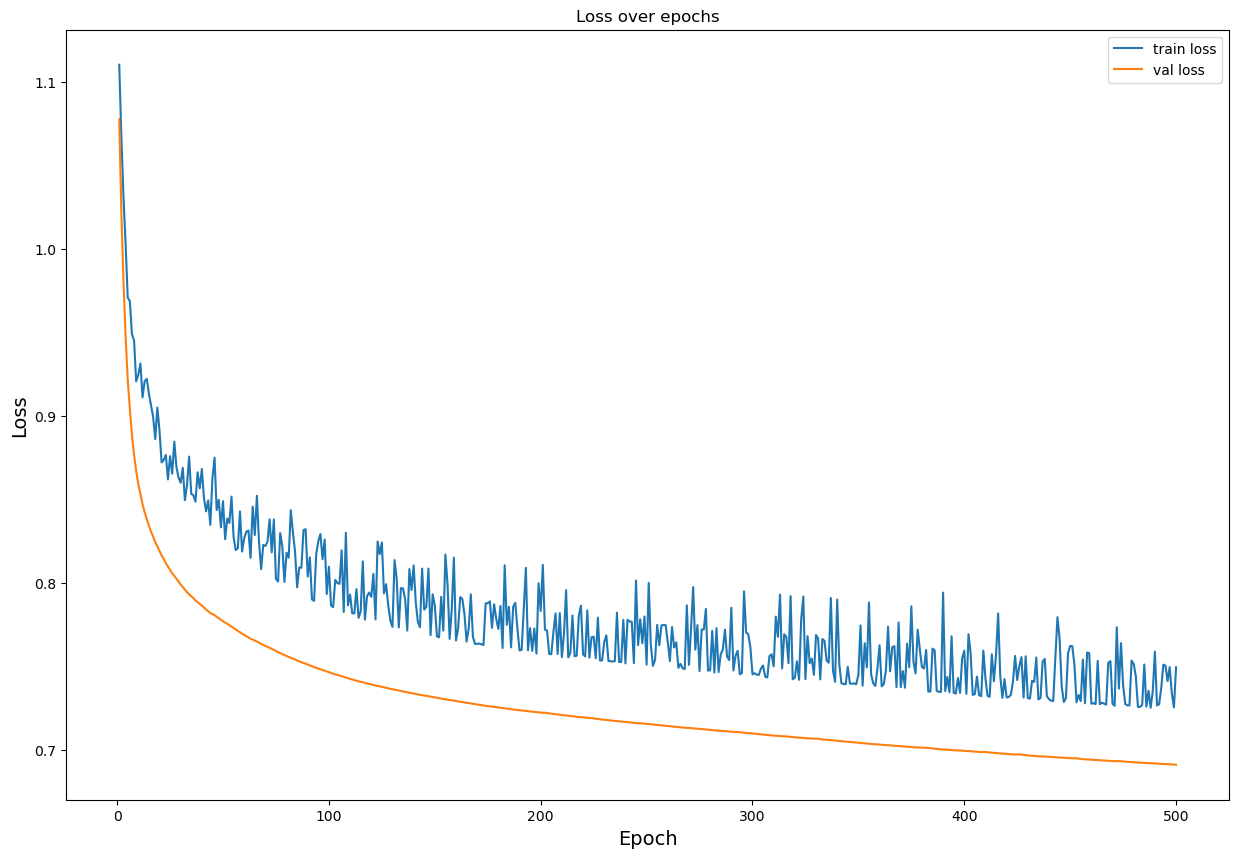

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, epochs+1), train_loss_epochs, label='train loss')
plt.plot(range(1, epochs+1), val_loss_epochs, label='val loss')
plt.xlabel("Epoch", size=14)
plt.ylabel("Loss", size=14)
plt.title("Loss over epochs")
plt.legend()
plt.show()

In [9]:
test_set = all_data['combined']['test']
parts = test_set.parts
parts_idx_map = test_set.parts_idx
loaded_part_models = []
for part in parts:
    m = models.get_model_class(part)
    m.load_state_dict(torch.load('./trained_models/{}_meta_weights.pth'.format(part)))
    loaded_part_models.append(m)



In [10]:
test_dataloader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [11]:
test_part_preds = []
test_benign_preds = []



model.eval()
for i in range(len(test_set)):
    image, part, binary_label = test_set.images[i], test_set.labels[i], test_set.binary_labels[i]
    with torch.no_grad():
        # Predict which body part
        x = image.unsqueeze(0)
        x_scaled = (x-pixel_means)/pixel_stds
        x_scaled = x_scaled.unsqueeze(1)
        x = x.unsqueeze(1)
        out = model.forward(x_scaled)
        y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)

        idx = torch.argmax(y_pred).item()
        
        # Choose next model and predict if cancer or no cancer
        leaf_model = loaded_part_models[idx]
        leaf_model.eval()
        out_2 = leaf_model.forward(x)
        y2_pred = int(out_2.round().item())
        
        test_part_preds.append(y_pred)
        test_benign_preds.append(y2_pred)
        
        
        

In [12]:
test_part_preds = torch.stack(test_part_preds).squeeze(1)
test_benign_preds = torch.tensor(test_benign_preds).unsqueeze(1)

correct = (test_part_preds == test_set.labels).sum().item() / num_classes
test_acc = correct / test_set.labels.size(0)
print(test_acc)

test_acc_2 = (torch.squeeze(test_benign_preds).eq(test_set.binary_labels)).sum().item() / test_set.binary_labels.size(dim=0)
print(test_acc_2)


0.9066666666666667
0.72


In [13]:
from sklearn.metrics import confusion_matrix

true_body_part_labels = torch.argmax(test_set.labels, dim=1).numpy()
pred_body_part_labels = torch.argmax(test_part_preds, dim=1).numpy()

body_part_cm = confusion_matrix(true_body_part_labels, pred_body_part_labels)

binary_preds = (test_benign_preds > 0.5).int().squeeze().numpy()
binary_labels = test_set.binary_labels.numpy()

cancer_cm_list = []
for part in range(3):
    indices = np.where(true_body_part_labels == part)
    cancer_cm = confusion_matrix(binary_labels[indices], binary_preds[indices])
    cancer_cm_list.append(cancer_cm)

cancer_cm_combined = np.sum(cancer_cm_list, axis=0)

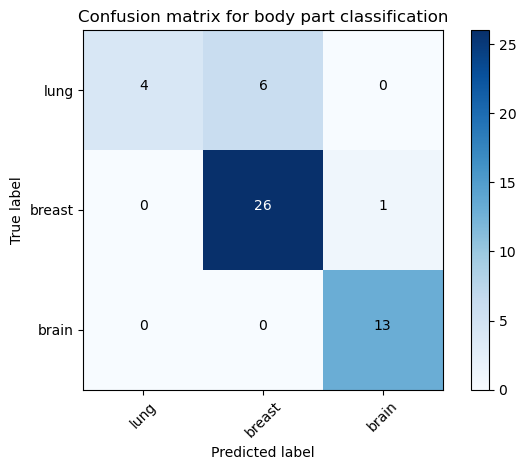

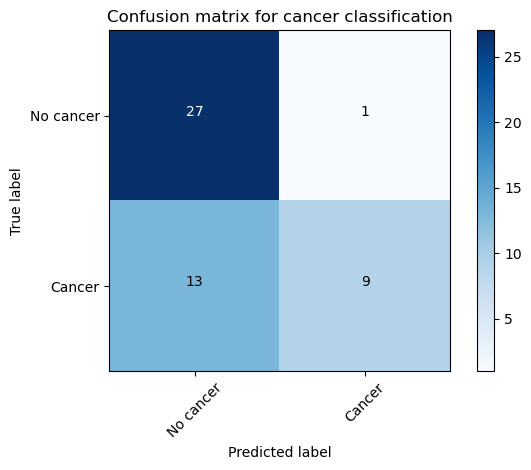

In [14]:
import itertools

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot confusion matrix for body part classification
plt.figure()
plot_confusion_matrix(body_part_cm, classes=parts,
                      title='Confusion matrix for body part classification')
plt.show()

# Plot confusion matrix for cancer classification
plt.figure()
plot_confusion_matrix(cancer_cm_combined, classes=['No cancer', 'Cancer'],
                      title='Confusion matrix for cancer classification')
plt.show()


In [15]:
import scipy.ndimage as nd

def surfd(input1, input2, sampling=1, connectivity=1):
    
    input_1 = np.atleast_1d(input1.astype(bool))
    input_2 = np.atleast_1d(input2.astype(bool))
	
    conn = nd.generate_binary_structure(input_1.ndim, connectivity)

    S = input_1 ^ nd.binary_erosion(input_1, conn)
    Sprime = input_2 ^ nd.binary_erosion(input_2, conn)
	
    dta = nd.distance_transform_edt(~S,sampling)
    dtb = nd.distance_transform_edt(~Sprime,sampling)
    
    sds = np.concatenate([np.ravel(dta[Sprime!=0]), np.ravel(dtb[S!=0])])
        
    return sds

In [16]:
print('Precision for Body Part Classification: %.3f' % precision_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('Recall for Body Part Classification : %.3f' % recall_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('F1 Score (DICE Coefficient) for Body Part Classification: %.3f' % f1_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('Mean Surface Distance for Body Part Classification %.3f'% surfd(true_body_part_labels, pred_body_part_labels).mean())
print('Cohen Kappa Score for Body Part Classification: %.3f' % cohen_kappa_score(true_body_part_labels, pred_body_part_labels))

Precision for Body Part Classification: 0.880
Recall for Body Part Classification : 0.860
F1 Score (DICE Coefficient) for Body Part Classification: 0.841
Mean Surface Distance for Body Part Classification 3.286
Cohen Kappa Score for Body Part Classification: 0.752


In [17]:

print('Precision for Cancer Classification: %.3f' % precision_score(binary_labels, binary_preds, average='weighted'))
print('Recall for Cancer Classification : %.3f' % recall_score(binary_labels, binary_preds, average='weighted'))
print('F1 Score (DICE Coefficient) for Cancer Classification: %.3f' % f1_score(binary_labels, binary_preds, average='weighted'))
print('Mean Surface Distance for Cancer Classification %.3f'% surfd(binary_labels, binary_preds).mean())
print('Cohen Kappa Score for Cancer Classification: %.3f' % cohen_kappa_score(binary_labels, binary_preds))

Precision for Cancer Classification: 0.774
Recall for Cancer Classification : 0.720
F1 Score (DICE Coefficient) for Cancer Classification: 0.692
Mean Surface Distance for Cancer Classification 2.000
Cohen Kappa Score for Cancer Classification: 0.397


In [18]:
cancer_type = ['Lung', 'Breast', 'Brain']
for p in range(3):
    indices = np.where(true_body_part_labels == p)
    cancer_labels = []
    cancer_preds=[]
    print('Precision for ' + cancer_type[p]+ ' Cancer Classification: %.3f' % precision_score(binary_labels[indices], binary_preds[indices], average='weighted', zero_division= False))
    print('Recall for  ' +cancer_type[p]+ '  Cancer Classification : %.3f' % recall_score(binary_labels[indices], binary_preds[indices], average='weighted', zero_division= False))
    print('F1 Score (DICE Coefficient) for ' + cancer_type[p]+ ' Cancer Classification: %.3f' % f1_score(binary_labels[indices], binary_preds[indices], average='weighted'))
    print('Mean Surface Distance for ' + cancer_type[p] + ' Cancer Classification %.3f'% surfd(binary_labels[indices], binary_preds[indices]).mean())
    print('Cohen Kappa Score for ' + cancer_type[p] + ' Cancer Classification: %.3f\n' % cohen_kappa_score(binary_labels[indices], binary_preds[indices]))
    

    

Precision for Lung Cancer Classification: 0.800
Recall for  Lung  Cancer Classification : 0.600
F1 Score (DICE Coefficient) for Lung Cancer Classification: 0.567
Mean Surface Distance for Lung Cancer Classification 2.500
Cohen Kappa Score for Lung Cancer Classification: 0.286

Precision for Breast Cancer Classification: 0.787
Recall for  Breast  Cancer Classification : 0.667
F1 Score (DICE Coefficient) for Breast Cancer Classification: 0.588
Mean Surface Distance for Breast Cancer Classification 3.455
Cohen Kappa Score for Breast Cancer Classification: 0.208

Precision for Brain Cancer Classification: 0.936
Recall for  Brain  Cancer Classification : 0.923
F1 Score (DICE Coefficient) for Brain Cancer Classification: 0.924
Mean Surface Distance for Brain Cancer Classification 0.200
Cohen Kappa Score for Brain Cancer Classification: 0.843

